In [ ]:
!pip install -U sentence-transformers
!pip install networkx matplotlib

In [60]:
import nltk
nltk.download('punkt')
from sklearn.metrics.pairwise import cosine_similarity
from nltk.tokenize import word_tokenize
import numpy as np
import requests

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [61]:
"""References"""
# Define the API endpoint URL
url = 'https://api.semanticscholar.org/graph/v1/paper/search'

# paper name 기입
query_params = {'query': query}
api_key = 'HITuTUEq1O8WDS21CSF1L84rz3GbFAy73wwNQC24'
headers = {'x-api-key': api_key}

response = requests.get(url, params=query_params, headers=headers).json()
paper_id = response['data'][0]['paperId']

fields = '?fields=title,publicationDate,influentialCitationCount,contexts,intents'
"""
  context ; snippets of text where the reference is mentioned
  intents ; intents derived from the contexts in which this citation is mentioned.
"""

url = f'https://api.semanticscholar.org/graph/v1/paper/{paper_id}/references'+ fields

# Send the API request
response = requests.get(url=url, headers=headers).json()
response['data']

[{'contexts': ['Honovich et al., 2022; Wang et al., 2022): Given just a handful of human-written examples of how an API can be used, we let a LM annotate a huge language modeling dataset with potential API calls.'],
  'intents': ['methodology'],
  'citedPaper': {'paperId': 'e65b346d442e9962a4276dc1c1af2956d9d5f1eb',
   'title': 'Self-Instruct: Aligning Language Models with Self-Generated Instructions',
   'influentialCitationCount': 118,
   'publicationDate': '2022-12-20'}},
 {'contexts': ['Honovich et al., 2022; Wang et al., 2022): Given just a handful of human-written examples of how an API can be used, we let a LM annotate a huge language modeling dataset with potential API calls.'],
  'intents': ['methodology'],
  'citedPaper': {'paperId': '6f4cc536f9ed83d0dbf7e919dc609be12aa0848a',
   'title': 'Unnatural Instructions: Tuning Language Models with (Almost) No Human Labor',
   'influentialCitationCount': 18,
   'publicationDate': '2022-12-19'}},
 {'contexts': ['…(Komeili et al., 2022

# Citations

In [62]:
def query2citations(query, num=20):
    # Define the API endpoint URL
    url = 'https://api.semanticscholar.org/graph/v1/paper/search'

    # paper name 기입
    query_params = {'query': query,'fields': 'citations,citations.influentialCitationCount,citations.title,citations.publicationDate,citations.abstract'}

    # semantic scholarship api 넣는다.
    api_key = 'HITuTUEq1O8WDS21CSF1L84rz3GbFAy73wwNQC24'
    headers = {'x-api-key': api_key}

    citations_response = requests.get(url, params=query_params, headers=headers).json()
    paper_id = citations_response['data'][0]['paperId']

    url = f'https://api.semanticscholar.org/graph/v1/paper/{paper_id}?fields=abstract,title'

    target_response = requests.get(url, params=query_params, headers=headers).json()

    return target_response, sorted(citations_response['data'][0]['citations'], key=get_citation_count, reverse=True)[:num]

def get_citation_count(item):
    influential_citation_count = item.get('influentialCitationCount')
    if influential_citation_count is not None:
        return influential_citation_count
    else:
        return 0

query = 'Toolformer: Language Models Can Teach Themselves to Use Tools'

## 상위 20개의 citation이 많은 논문들을 select
num=20
target_response, citation_response = query2citations(query=query,num=num)

In [63]:
print(target_response)
print(citation_response[0])

{'paperId': '53d128ea815bcc0526856eb5a9c42cc977cb36a7', 'title': 'Toolformer: Language Models Can Teach Themselves to Use Tools', 'abstract': 'Language models (LMs) exhibit remarkable abilities to solve new tasks from just a few examples or textual instructions, especially at scale. They also, paradoxically, struggle with basic functionality, such as arithmetic or factual lookup, where much simpler and smaller models excel. In this paper, we show that LMs can teach themselves to use external tools via simple APIs and achieve the best of both worlds. We introduce Toolformer, a model trained to decide which APIs to call, when to call them, what arguments to pass, and how to best incorporate the results into future token prediction. This is done in a self-supervised way, requiring nothing more than a handful of demonstrations for each API. We incorporate a range of tools, including a calculator, a Q\\&A system, two different search engines, a translation system, and a calendar. Toolformer

In [64]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F

#Mean Pooling - Take attention mask into account for correct averaging
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# sentence-transformers로 embedding 후 abstract간 cosine similarity를 측정하였다.
tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')
model = AutoModel.from_pretrained('sentence-transformers/all-MiniLM-L6-v2')

In [65]:
abs_dict = {}

abs_dict[target_response['title']] = target_response['abstract']

for keyword in citation_response:
    paper_id, title = keyword['paperId'], keyword['title']
    abstract = str(keyword['abstract'])
    abs_dict[title] = abstract

sentences = list(abs_dict.values())
# abstract tokenize
encoded_input = tokenizer(sentences, padding=True, truncation=True, return_tensors='pt')

# Compute token embeddings
with torch.no_grad():
    model_output = model(**encoded_input)

# Perform pooling
sentence_embeddings = mean_pooling(model_output, encoded_input['attention_mask'])

# Normalize embeddings
sentence_embeddings = F.normalize(sentence_embeddings, p=2, dim=1)

print(cosine_similarity(sentence_embeddings))

[[1.0000001  0.5513477  0.5771176  0.57341564 0.6215799  0.6275703
  0.5799413  0.7308853  0.5933709  0.5766277  0.5803348  0.72984713
  0.60641825 0.13352083 0.5145589  0.53031296 0.59344906 0.42087173
  0.47988105 0.4593428  0.6100238 ]
 [0.5513477  1.         0.647599   0.4160602  0.5820585  0.69219315
  0.48361295 0.6035037  0.34910518 0.5121375  0.5168822  0.5546273
  0.5631851  0.15926427 0.35566932 0.6291634  0.573259   0.39048585
  0.3852418  0.51833594 0.47294536]
 [0.5771176  0.647599   1.0000001  0.50449693 0.65199447 0.7156489
  0.54823184 0.6131887  0.41446567 0.4982016  0.4906584  0.53359264
  0.5611518  0.09674283 0.48995155 0.63928604 0.6356156  0.47678238
  0.53104913 0.48595    0.5849805 ]
 [0.57341564 0.4160602  0.50449693 1.         0.47918537 0.5376586
  0.4573899  0.5817758  0.49041942 0.432725   0.39981136 0.56775767
  0.47828782 0.11113564 0.42182758 0.48425722 0.55703926 0.33578226
  0.65029776 0.47049546 0.6179733 ]
 [0.6215799  0.5820585  0.65199447 0.4791853

# Graph

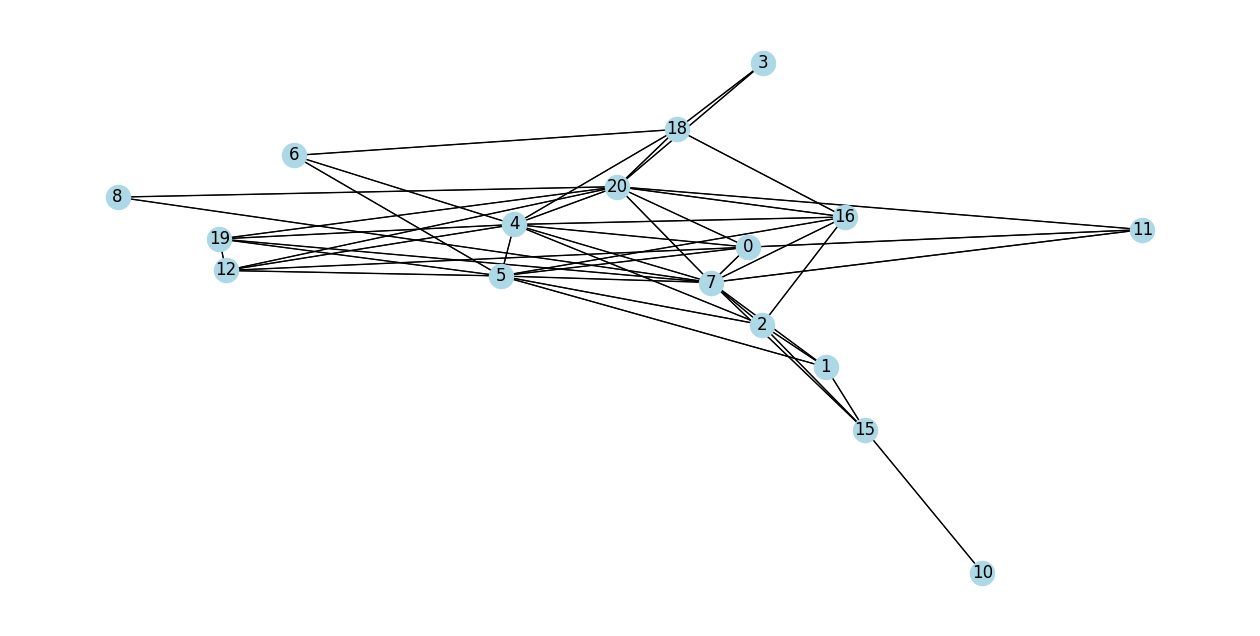

'1이 target paper이다.'

In [83]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler

plt.figure(figsize=(16,8))
scaler = MinMaxScaler()


# target + citation paper 간의 similarity matrix
abs_sim = cosine_similarity(sentence_embeddings)
np.fill_diagonal(abs_sim, 0) # 대각 행렬 0으로 설정

# n x n 인접 행렬 생성
n = len(abs_dict)
adj_matrix = abs_sim

# NetworkX 그래프 객체 생성
G = nx.from_numpy_array(adj_matrix)

# target + citation paper name
# node = list(abs_dict.keys())
node = np.arange(len(abs_dict.keys()))
G.add_nodes_from(node)

threshold = 0.6
edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] <= threshold]
G.remove_edges_from(edges_to_remove)

# 위치 결정
pos = nx.spring_layout(G)

# 고립된 노드 찾기 및 제거 >> edge=0 or 1 인 node 제거
isolated = [node for node, degree in G.degree() if degree <= 1]
G.remove_nodes_from(isolated)

# 엣지 그리기 (가중치에 따라 굵기 조절)
for (u, v, d) in G.edges(data=True):
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=d['weight'])

# 레이블 추가
# nx.draw_networkx_labels(G, pos)
nx.draw(G, pos, labels={node: node for node in G.nodes()}, node_color='lightblue')#, node_size=500)
plt.show()

"""0이 target paper이다."""

In [87]:
abs_lst = list(abs_dict.keys())
abs_lst

['Toolformer: Language Models Can Teach Themselves to Use Tools',
 'Llama 2: Open Foundation and Fine-Tuned Chat Models',
 'A Survey of Large Language Models',
 'Program of Thoughts Prompting: Disentangling Computation from Reasoning for Numerical Reasoning Tasks',
 'HuggingGPT: Solving AI Tasks with ChatGPT and its Friends in Hugging Face',
 'Qwen Technical Report',
 'Reflexion: language agents with verbal reinforcement learning',
 'ToolLLM: Facilitating Large Language Models to Master 16000+ Real-world APIs',
 'ViperGPT: Visual Inference via Python Execution for Reasoning',
 'Lost in the Middle: How Language Models Use Long Contexts',
 'Enabling Large Language Models to Generate Text with Citations',
 'Gorilla: Large Language Model Connected with Massive APIs',
 'Mind2Web: Towards a Generalist Agent for the Web',
 'A Survey on Large Language Model based Autonomous Agents',
 'Segment Everything Everywhere All at Once',
 'A Survey on Evaluation of Large Language Models',
 'LLM+P: Empow

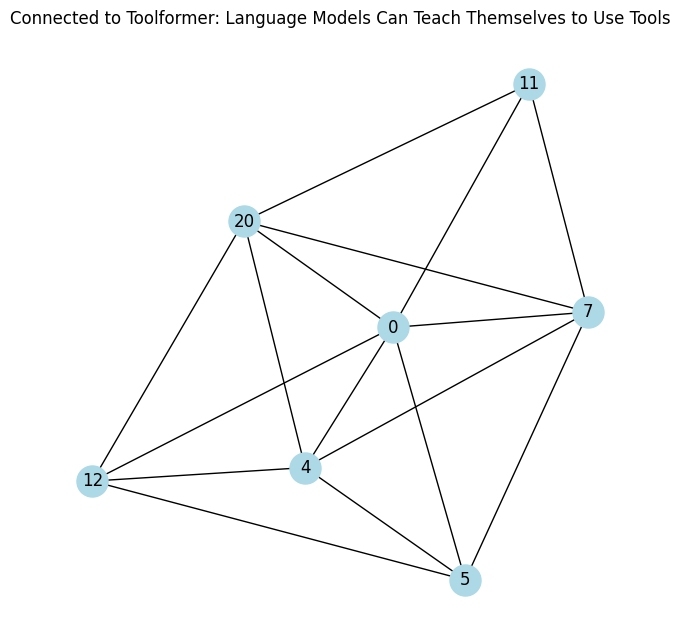

In [92]:
first_node = list(G.nodes)[0]  # 첫 번째 노드
connected_nodes = [first_node] + [n for n in G.neighbors(first_node)]

# 하위 그래프 생성
subgraph = G.subgraph(connected_nodes)

# 하위 그래프 그리기
plt.figure(figsize=(6, 6))
nx.draw(subgraph, with_labels=True, node_color='lightblue', node_size=500)
plt.title(f"Connected to {abs_lst[0]}")
plt.show()